In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import IPython.display as display
from IPython.display import clear_output
import sys
import time
import datetime
import os


torch.manual_seed(111)

c:\Users\kuzga\OneDrive\Рабочий стол\ShiftLab-2024-Computer-Vision\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")
# if torch.cuda.is_available():
#     device = torch.device("cuda")
print(f"Device is {device}")

Device is cpu


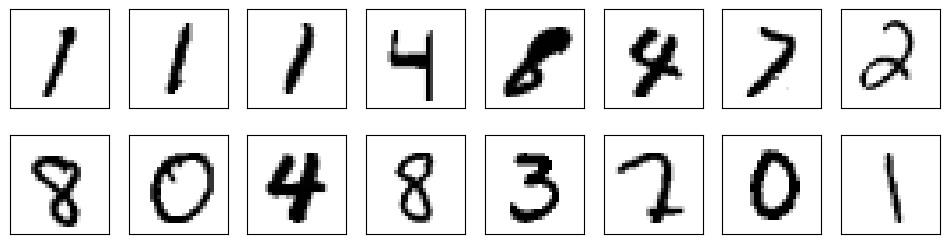

In [3]:
batch_size = 32

input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = torchvision.datasets.MNIST('.', train=True, transform=input_transform, download=True)
test_dataset = torchvision.datasets.MNIST('.', train=False, transform=input_transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

real_samples, mnist_labels = next(iter(train_loader))
plt.figure(figsize=(12, 3))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(real_samples[i].squeeze(), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [4]:
def label_to_onehot(labels, length=10):
    batch_size = labels.size(0)
    canvas = torch.zeros(batch_size, length)
    labels = labels.view(-1, 1)
    return canvas.scatter_(1, labels, 1)


def make_binary_labels(num_one, num_zero):
    ones = torch.ones(1, num_one)
    zeros = torch.zeros(1, num_zero)
    return torch.cat([ones, zeros], dim=1).view(-1, 1)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(110, 256),
            nn.ELU(),
            nn.Linear(256, 512),
            nn.ELU(),
            nn.Linear(512, 1024),
            nn.ELU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, z, c):
        x = torch.cat([z, c], dim=1)
        x = self.mlp(x)
        return x.view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(794, 1024),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, c):
        img = img.view(-1, 28 * 28)
        x = torch.cat([img, c], dim=1)
        x = self.mlp(x)
        return x


discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [6]:
lr = 1e-4
num_epochs = 50
# loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

In [7]:
output_dir = datetime.datetime.now().strftime("MNIST-GAN-EVO_%Y-%m-%d_%H-%M-%S")
os.makedirs(output_dir, exist_ok=True)

num_epochs = 100
fixed_noise = torch.randn(10, 100).to(device)
for epoch in range(num_epochs):
    print('epoch', epoch, end=' ')
    # Train
    for img, label in tqdm(train_loader):
        real = img.to(device)
        onehot = label_to_onehot(label).to(device)
        batch_size = real.size(0)

        # Discriminator
        discriminator.train()
        generator.eval()
        z = torch.randn(batch_size, 100).to(device)
        fake = generator(z, onehot).detach()

        fake_out = discriminator(fake, onehot)
        real_out = discriminator(real, onehot)

        fake_y = make_binary_labels(0, batch_size).to(device)
        real_y = make_binary_labels(batch_size, 0).to(device)

        fake_loss = F.binary_cross_entropy(fake_out, fake_y)
        real_loss = F.binary_cross_entropy(real_out, real_y)

        loss = fake_loss + real_loss
        optimizer_discriminator.zero_grad()
        loss.backward()
        optimizer_discriminator.step()

        # Generator
        generator.train()
        discriminator.eval()
        z = torch.randn(batch_size, 100).to(device)
        fake = generator(z, onehot)
        fake_out = discriminator(fake, onehot)
        y = make_binary_labels(batch_size, 0).to(device)

        loss = F.binary_cross_entropy(fake_out, y)
        optimizer_generator.zero_grad()
        loss.backward()
        optimizer_generator.step()

    # Test
    discriminator.eval()
    generator.eval()

    labels = torch.arange(10).long()
    onehot = label_to_onehot(labels)

    fake = generator(fixed_noise, onehot)
    plt.figure(figsize=(20, 2))
    for i in range(10):
        label = labels[i]
        img = fake[i][0].detach()
        plt.subplot(1, 10, i + 1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    plt.savefig(f"{output_dir}/{epoch}.png")

torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
}, f"{output_dir}/state_dict.pkl")

epoch 0 

 32%|███▏      | 603/1875 [00:16<00:34, 37.24it/s]


KeyboardInterrupt: 